# Operations and attributes of geometry column

In this example we learn more about ```geometry``` column type. It is a special data type which we can compare to time series. The main difference is that we operate in two dimensions.

```geometry``` column field may store:

- Point (_0 D_)
- Line (_1 D_)
- Polygon (_2 D_)

or all of them. Usually we operate on one type of geometry and it is related to the specific use case. If you build __A*__ algorithm then you work with line segments; for __distance__ calculations points are the best fit; and polygons allow us to work with __aggregated processes over specified areas__ such as annual GDP index per country.

## Step 1: Import packages and read data

Read file ```nypp_20d/nypp.shp``` with borders of police precints in NYC. Check ```info()``` and ```plot()``` those polygons.

In [1]:
# Import packages

import numpy as np
import geopandas as gpd

In [2]:
# Read and info

gdf = gpd.read_file('nypp_20d/nypp.shp')
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Precinct    77 non-null     int64   
 1   Shape_Leng  77 non-null     float64 
 2   Shape_Area  77 non-null     float64 
 3   geometry    77 non-null     geometry
dtypes: float64(2), geometry(1), int64(1)
memory usage: 2.5 KB


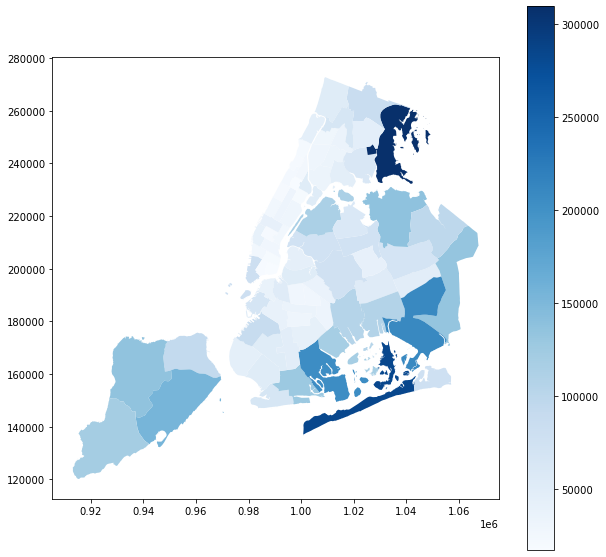

In [3]:
# Plot

gdf.plot(figsize=(10, 10), column='Shape_Leng', cmap='Blues', legend=True);

## Step 2: Analyze attributes of a GeoDataFrame (and GeoSeries)

We will test those **attributes**:

- area,
- bounds,
- total_bounds,
- geom_type,
- is_valid.

In [4]:
gdf['area_gpd'] = gdf.area

In [5]:
(gdf['Shape_Area'] == gdf['area_gpd']).any()

False

This is interesting observation: area of police precint district calculated from the polygons is not equal area given with the ```GeoDataFrame```. You should be cautious with spatial calculations - if borders of polygons are irregular then calculations introduce errors. To prove it let's visualize errors in choropleth map.

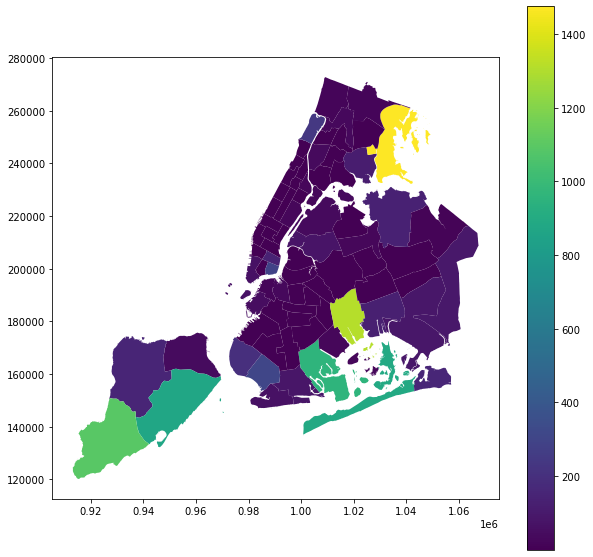

In [6]:
gdf['area_error'] = np.sqrt((gdf['Shape_Area'] - gdf['area_gpd'])**2)
gdf.plot(figsize=(10, 10), column='area_error', cmap='viridis', legend=True);

> **IMPORTANT** Spatial calculations may slightly differ due to the errors introduced by finite resolution of measuremnt instruments and finite number of points used for data representation. Python equal operator ```==``` may be misleading and can cause hard-to-track bugs in your application. The better idea is to track percent of difference between calculations and if it relatively small then assume that two variables are equal.

In [10]:
smape_n = np.abs(gdf['area_gpd'] - gdf['Shape_Area'])
smape_d = (np.abs(gdf['area_gpd']) + np.abs(gdf['Shape_Area'])) / 2

smape = np.mean(100 * smape_n / smape_d)
print(f'Symmetrical Mean Absolute Percentage Error of prediction is {smape}%')

Symmetrical Mean Absolute Percentage Error of prediction is 9.301398474402119e-05%


In [11]:
# Bounds of each unit

gdf.bounds

,minx,miny,maxx,maxy
0,9.710135e+05,188082.322388,9.851448e+05,205061.942383
1,9.825008e+05,197080.708801,9.873992e+05,203570.984192
2,9.803090e+05,203570.984192,9.868124e+05,209792.183838
3,9.862400e+05,197630.773193,9.916086e+05,202660.992004
4,9.851448e+05,201209.096008,9.921191e+05,206998.443237
...,...,...,...,...
72,1.011966e+06,211277.195801,1.025221e+06,226196.820984
73,9.475857e+05,158542.817993,9.693753e+05,175708.962036
74,9.270241e+05,143383.462036,9.507726e+05,174416.462830
75,9.370623e+05,132137.996033,9.705701e+05,161977.456604


In [12]:
# Bounds of whole GeoDataFrame

gdf.total_bounds

array([ 913175.10900879,  120121.88126121, 1067382.50842285,
        272844.29364014])

In [13]:
# Check geometry types

(gdf.geom_type).unique()

array(['MultiPolygon', 'Polygon'], dtype=object)

In [14]:
# Check if geometries are valid

all(gdf.is_valid)

True

## Step 3: Analyze methods of a GeoDataFrame (and GeoSeries)

**Methods**:

- distance(),
- centroid,
- representative_point(),
- to_crs(),
- plot().

__Centroid__ is the geometric center of figure. It is useful to calculate centroids of polygons if you want to reduce dimensionality of data.

In [15]:
# Get centroids

gdf['centroids'] = gdf.centroid

We may select some random point within polygon and treat it as representation of our figure. Use ```geodataframe.representative_point()``` method for it.

In [16]:
r_point = gdf.representative_point()

__Representative point__ is not the same as __centriod__. To prove it we can calculate distance between centroids and those randomly picked points.

In [18]:
# Distance from each representative point to centroid

distances = r_point.distance(gdf['centroids'])  # Be careful - see next cells

In [19]:
distances.mean()

1062.350406880198

In [20]:
# Distance from geodataframe's polygon to representative point !

gdf.distance(r_point).mean()

0.0

In [21]:
# Distance from centroids column to representative points

gdf['centroids'].distance(r_point).mean()

1062.350406880198

> **IMPORTANT** Only one column in GeoDataFrame has ```geometry``` flag and is used for all calculations. That's why distance from ```geometry``` column - polygons - to representative points is equal to 0. Those points are within geometry. On the other hand we can pick ```centroids``` column and calculate distances without any problems. We can assign ```geometry``` flag to ```centroids``` column too.

### CRS

Now we take a look into important parameter of each GeoSeries and GeoDataframe. It is CRS or Coordinate Reference System https://en.wikipedia.org/wiki/Spatial_reference_system

There are many of them and everyone has different purpose. As example system with name EPSG:4326 is used by GPS trackers and EPSG:2180 fits best data from Poland country (lowest distortions). Some systems are in meters and other in degrees. Let's compare map of the New York City with different CRS.

In [22]:
# Few different CRS / EPSG

epsg_mercator_spherical = 'EPSG:3857'
epsg_gps = 'EPSG:4326'
epsg_north_america = '+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m no_defs'

In [23]:
# CRS of our GeoDataFrame

gdf.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

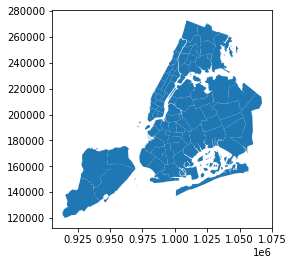

In [24]:
# Plot and look into the axes

gdf.plot()

In [25]:
# Test other crs

gdf1 = gdf.to_crs(epsg_mercator_spherical)

In [26]:
gdf1.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

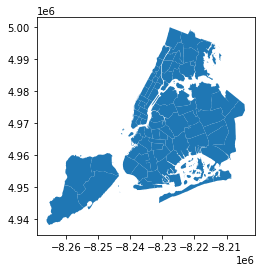

In [27]:
gdf1.plot()

In [28]:
gdf2 = gdf.to_crs(epsg_gps)

In [29]:
gdf2.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

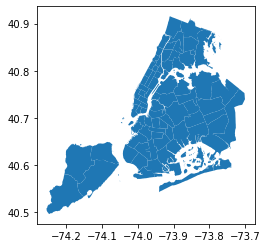

In [30]:
gdf2.plot()

In [31]:
gdf3 = gdf.to_crs(epsg_north_america)

In [32]:
gdf3.crs

<Projected CRS: +proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

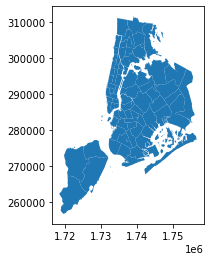

In [33]:
gdf3.plot()

> **IMPORTANT** Your datasets must have the same crs if you perform spatial operations. Always! Usually we check crs at the beginnig of all calculations and it should be the first task, even before checking NaN's in dataset, especially if you perform many spatial joins.

---